# Part-of-Speech Tagging using Bidirectional LSTM

The LSTM unit is considered the most complex RNN model but the most effective, especially when dealing with long text sequences.

The NLTK package comes with a million-word electronic corpus of tagged English words, created at Brown University (USA). It consists of 500 text documents, the longest consisting of just over 2,000 words. The text documents were sampled from 15 different text categories, where the number of documents in each category varies. It is well-known for setting the bar for scientific study of the frequency and distribution of word categories in everyday language use.

Import the tagged Brown corpus from `nltk.corpus`, but re-tag each word with part-of-speech using NLTK's **universal tagset**. The default tags in the Brown corpus do not necessarily match the universally-accepted tagging syntax, so it is common to map to these universal settings when using the Brown corpus. Then you can create the input data (tokenized words per document) and target data (the corresponding POS tags).

As with any text processing task in an RNN network, the important size variables to remember are:

    V vocabulary size of corpus
    N number of samples
    T sequence length
    D number of input features
    M number of hidden neurons
    K number of neurons in outer dense layer

## Create data for LSTM model

In [1]:
import nltk
from nltk.corpus import brown

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\shmel\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\shmel\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

**You import the brown corpus with the universal tagset by using `tagged_words()` or `tagged_sents()` function. In this case, you should tag the sentences, which produces a list of (list of (str,str)), i.e. list of sentences where each word is tagged with part-of-speech. By convention, the tagged word is represented using a tuple consisting of the token and the POS tag.**

In [3]:
corpus = brown.tagged_sents(tagset='universal')

In [6]:
print('There are', len(corpus), 'sentences in the corpus')

There are 57340 sentences in the corpus


In [7]:
# 1st text document tagged with parts-of-speech

corpus[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [8]:
# Separate corpus into lists (sentences) of words and lists of corresponding POS tags (input and output)

inputs = []
targets = []

for sentence_tag_pairs in corpus:
    tokens = [] 
    target = [] 
    for token, tag in sentence_tag_pairs:
        tokens.append(token) 
        target.append(tag) 
        
    inputs.append(tokens) 
    targets.append(target)

In [9]:
inputs[0]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of',
 "Atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 '``',
 'no',
 'evidence',
 "''",
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.']

In [10]:
targets[0]

['DET',
 'NOUN',
 'NOUN',
 'ADJ',
 'NOUN',
 'VERB',
 'NOUN',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 'ADJ',
 'NOUN',
 'NOUN',
 'VERB',
 '.',
 'DET',
 'NOUN',
 '.',
 'ADP',
 'DET',
 'NOUN',
 'VERB',
 'NOUN',
 '.']

In [11]:
# Check that each token in input has corresponding POS tag in output

len(inputs[0]) == len(targets[0])

True

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [14]:
# Train-test split input and target data before converting words to integers

train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.3)

In [19]:
print('There are', len(train_inputs), 'sentences in the training set')

There are 40138 sentences in the training set


In [17]:
len(train_targets)

40138

In [20]:
print('There are', len(test_inputs), 'sentences in the test set')

There are 17202 sentences in the test set


In [18]:
len(test_targets)

17202

## Convert sentences to sequences of integers

**Use TensorFlow `Tokenizer` to convert the lists of words into sequences of integers, with automatic generation of the corpus vocabulary in mapping dictionaries.**

**In this case, do not set a maximum word count for the tokenizer because you want a unique tag for each word. More importantly, make sure to assign unknown words from the test set with an 'UNK' tag (unknown) to stop the tokenizer from removing unknown words and misaligning the input words with the target outputs. It is important to keep all the words, even the unknown ones.**

In [21]:
MAX_VOCAB_SIZE = None

# Capitalization might be useful e.g. Bill vs the bill
should_lowercase = False

# Otherwise unknown words will be removed, and len(input) != len(target)
word_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=should_lowercase, oov_token='UNK')

In [22]:
# Train tokenizer and transform sentences into sequences of integers

word_tokenizer.fit_on_texts(train_inputs)

train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)

test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [28]:
train_inputs_int[0:5]

[[9145, 84, 330, 14, 29, 29],
 [195, 209, 64, 13, 2433, 20, 435, 10, 116, 72, 96, 14, 29, 29],
 [12021, 200, 2586, 1230, 24, 24],
 [2782, 178, 2888, 190, 14, 4],
 [12022, 17959, 32, 2, 3327, 4]]

In [29]:
len(train_inputs_int)

40138

In [24]:
# Get word->index mapping

word2idx = word_tokenizer.word_index

V = len(word2idx)

print('Found %s unique tokens in training corpus' % V)

Found 47461 unique tokens in training corpus


In [ ]:
word2idx['Monday']

**You can 'flatten' the target data in training and test sets to check that both sets contain the same target classes. Once flattened, convert the single list into a `set` to list unique values only.** 

**NOTE: The flatten function below has been copied from StackOverflow https://stackoverflow.com/questions/11264684/flatten-list-of-lists.**

In [30]:
# Function to flatten a list of lists into a single list of unique values

def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist] 
    return flattened

In [31]:
all_train_targets = set(flatten(train_targets))

all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [32]:
all_test_targets = set(flatten(test_targets))

all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [33]:
# Check that POS targets match in training and test sets

all_train_targets == all_test_targets

True

## Convert POS tags to sequences of integers

**Using TensorFlow `Tokenizer` again, convert the lists of POS tags in the target data to sequences of integers as the necessary input format for the LSTM model. There is no need to set maximum vocabulary size or allocate unknown tokens since the set of target classes is consistent and small.**

**NOTE: The Tokenizer does not use class 0 (index starts from 1), leading to an extra class when converting tags to integers.** 

In [34]:
tag_tokenizer = Tokenizer()

tag_tokenizer.fit_on_texts(train_targets)

# Transform targets to integers
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)

test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

In [35]:
train_targets_int[0:5]

[[2, 5, 1, 3, 3, 3],
 [8, 2, 3, 3, 2, 8, 2, 5, 1, 4, 8, 3, 3, 3],
 [2, 7, 6, 1, 3, 3],
 [2, 2, 8, 1, 3, 3],
 [1, 2, 4, 5, 1, 3]]

In [36]:
len(train_targets_int)

40138

In [37]:
# Save unpadded version of targets for later (see calculating true model accuracy below)

train_targets_int_unpadded = train_targets_int

test_targets_int_unpadded = test_targets_int

In [ ]:
# Number of classes (remember to add class to count for zero even though it won't be used/negligible when predicted)

K = len(tag_tokenizer.word_index) + 1

K

In [ ]:
tag_tokenizer.word_index

## Pad sequences

**Before padding the sequences, find the maximum sequence length in both the training and test sets and assign to *T* variable. This is not cheating, since you do not want to 'truncate' any inputs within the RNN model as you would then have to truncate the targets, so you can insist on `maxlen` of size *T* when padding all the sequences.** 

In [38]:
# Assign max sequence length to T

maxlen_train = max(len(sent) for sent in train_inputs)

maxlen_test = max(len(sent) for sent in test_inputs)

# max() function takes the highest score
T = max((maxlen_train, maxlen_test))

In [42]:
T

180

In [43]:
# Pad all sequences to get a N x T matrix (sentences by sequence length)

train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)

print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (40138, 180)


In [44]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)

print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (17202, 180)


In [45]:
# Pad all sequences to same length to get N x T matrix (samples by sequence length)

train_targets_int = pad_sequences(train_targets_int, maxlen=T)

print('Shape of train targets tensor:', train_targets_int.shape)

Shape of train targets tensor: (40138, 180)


In [46]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)

print('Shape of test targets tensor:', test_targets_int.shape)

Shape of test targets tensor: (17202, 180)


## Create the model

**Since you are working with sequences of words, you need to include an `Embedding` layer to create the word embeddings matrix as input for the RNN layer. You select the embedding dimensionality (length of word vector), which you can vary to improve results.**

**IMPORTANT! There is a problem with the network as-is and you must include `mask_zero=True` which ignores any entries that are zero, i.e. those that were introduced by the 'padding'. You must do this so that the model results are actually correct. The downside is that it drastically slows down training, so a necessary evil if you want your model to work correctly (TensorFlow's fault).**

**In the case of POS tagging, use `Bidirectional` LSTM unit which essentially creates two LSTM units - one to read the sequences forward and another to read the sequences backward. The different hidden states are concatenated into a single vector (make sure to include `return_sequences=True` so that all hidden states are kept), and this helps to differentiate the context between synoyms, e.g. Bill and the bill.**

In [48]:
# Choose embedding dimensionality
D = 32

i = Input(shape=(T,))

# mask_zero=True is much slower on GPU (30 mins per epoch) than CPU (5 mins per epoch)!
x = Embedding(V + 1, D, mask_zero=True)(i)

x = Bidirectional(LSTM(32, return_sequences=True))(x)

x = Dense(K)(x)

model = Model(i, x)

In [49]:
# Compile model

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [50]:
print('Training model...') # takes approx. 20 mins

r = model.fit(train_inputs_int, 
              train_targets_int, 
              epochs=5, 
              validation_data=(test_inputs_int, test_targets_int))

Training model...
Epoch 1/5
1255/1255 [==============================] - 258s 198ms/step - loss: 0.4738 - accuracy: 0.8543 - val_loss: 0.1127 - val_accuracy: 0.9646
Epoch 2/5
1255/1255 [==============================] - 248s 197ms/step - loss: 0.0708 - accuracy: 0.9778 - val_loss: 0.0910 - val_accuracy: 0.9706
Epoch 3/5
1255/1255 [==============================] - 243s 194ms/step - loss: 0.0433 - accuracy: 0.9861 - val_loss: 0.0929 - val_accuracy: 0.9708
Epoch 4/5
1255/1255 [==============================] - 243s 193ms/step - loss: 0.0325 - accuracy: 0.9896 - val_loss: 0.0939 - val_accuracy: 0.9710
Epoch 5/5
1255/1255 [==============================] - 244s 194ms/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.0967 - val_accuracy: 0.9717


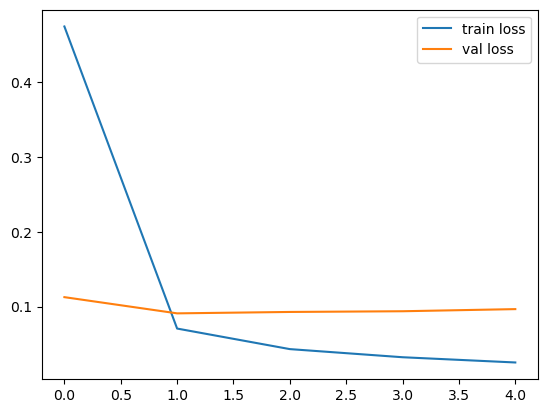

In [51]:
# Plot loss per epoch

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

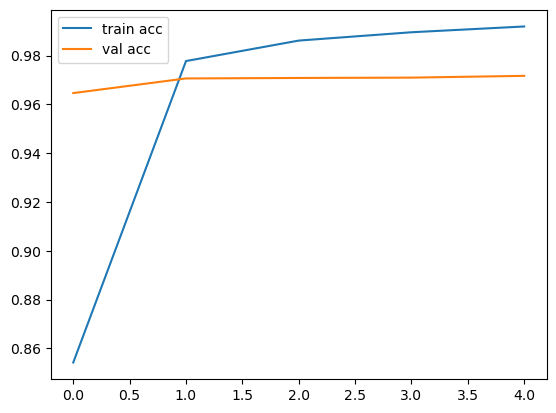

In [52]:
# Plot accuracy per epoch

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

**The results look different than usual, but this is expected. Training the model sees steady decline in losses as the model 'learns', and the test losses also decrease but only slightly in comparison, since the losses should not vary much. Same situation applies with accuracies, with test accuracy reaching approx. 97%.**


## True model accuracy

**As a sanity check, we can compare the accuracies plotted above with the 'true' model accuracy, i.e. without depending on the model's scoring method, meaning you calculate the accuracy using SciKit-Learn. This also can be used to confirm that `mask_zero=True` is working as expected.**

**Since we are working with the actual text sequences and targets, you will need the 'unpadded' version of the training and test targets saved earlier in the notebook. Once flattened (list of lists into a single list), you can use the flattened predicted labels from the model to run against in SciKit.**

In [53]:
# First get length of each sequence in training and test sets

train_lengths = []

for sentence in train_inputs:
    train_lengths.append(len(sentence))
    

test_lengths = []

for sentence in test_inputs:
    test_lengths.append(len(sentence))

In [54]:
# Generate predictions from training set - output is N x T x K probabilities (with padding)

train_probs = model.predict(train_inputs_int)

1255/1255 [==============================] - 56s 42ms/step


In [67]:
train_probs[0][0]

array([-0.07775498,  0.11272705,  0.06000294, -0.03366607, -0.04515938,
       -0.0341961 ,  0.04888181, -0.00594358, -0.1034944 , -0.10638877,
       -0.02482757, -0.08011083,  0.02757399], dtype=float32)

In [55]:
# Get the predicted label (index with highest probability) without padding

train_predictions = []

for probs, length in zip(train_probs, train_lengths):
    # probs is T x K, i.e. without padding
    probs_ = probs[-length:] 
    preds = np.argmax(probs_, axis=1) 
    train_predictions.append(preds)


In [71]:
train_predictions[0][0]

'VERB'

In [56]:
# Flatten training predictions and targets into single list (for use in SciKit-Learn)

flat_train_predictions = flatten(train_predictions)

flat_train_targets = flatten(train_targets_int_unpadded)

In [57]:
# Generate predictions from test set - output is N x T x K probabilities (with padding)

test_probs = model.predict(test_inputs_int)

# To get the single predictions (highest probability) without padding

test_predictions = []

for probs, length in zip(test_probs, test_lengths):
    # probs is T x K 
    probs_ = probs[-length:] 
    preds = np.argmax(probs_, axis=1) 
    test_predictions.append(preds)


538/538 [==============================] - 23s 42ms/step


In [58]:
# Flatten test predictions and targets into single list (for use in SciKit-Learn)

flat_test_predictions = flatten(test_predictions)

flat_test_targets = flatten(test_targets_int_unpadded)

In [59]:
# Run accuracy and F1-scores on both training and test sets

from sklearn.metrics import accuracy_score, f1_score

print("Training accuracy:", accuracy_score(flat_train_targets, flat_train_predictions))

print("Test accuracy:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Training F1-score:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))

print("Test F1-score:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Training accuracy: 0.9941650055275659
Test accuracy: 0.9717007428267648
Training F1-score: 0.9874203031602637
Test F1-score: 0.9325089375050927


**Excellent test scores - approx 97% accuracy and less optimistic 0.93 F1-score. As expected, training scores are higher but this indicates that the model is predicting well. You should confirm whether the classes are imbalanced**

## Baseline model accuracy 

**You may have the true accuracy scores for the model, but it is meaningless without a baseline to compare with, i.e. has the model performed better than another model. To establish a baseline, you need to create the simplest model possible, like collecting all the possible tags occurring for a single word in the training set and choose the most common, then running those results against the actual labels.** 


In [60]:
from collections import Counter

# Function to find the most frequent element in list
# (taken from https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list)

def most_common(lst):
    data = Counter(lst) 
    return data.most_common(1)[0][0]

In [61]:
# Map words to POS tags

token2tags = {k: [] for k, v in word2idx.items()}

# Remove unknown tokens
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
    for token, tag in zip(tokens, tags):
        if should_lowercase:
            token = token.lower() 
        if token in token2tags:
            token2tags[token].append(tag)

token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [62]:
# Generate predictions from training data

train_predictions = []

for sentence in train_inputs:
    predictions = [] 
    
    for token in sentence:
        if should_lowercase:
            token = token.lower() 
            
        predicted_tag = token2tag[token] 
        predictions.append(predicted_tag) 
        
    train_predictions.append(predictions)
    
    
# Flatten for use in SciKit    
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [63]:
# Generate predictions from test data

test_predictions = []

for sentence in test_inputs:
    predictions = []
    
    for token in sentence:
        predicted_tag = token2tag.get(token, 'INCORRECT') 
        predictions.append(predicted_tag) 
        
    test_predictions.append(predictions)
    
# Flatten for use in SciKit
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [64]:
print("Training accuracy:", accuracy_score(flat_train_targets, flat_train_predictions))

print("Test accuracy:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Training F1-score:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))

print("Test F1-score:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Training accuracy: 0.9571469152001298
Test accuracy: 0.9281455193321743
Training F1-score: 0.9385408599659658
Test F1-score: 0.8257540552170936


**The baseline model performs pretty well, which makes sense as there is only one possible tag for many words, but the model does perform better, which indicates that accounting for 'context' is useful. Better anyway than memorizing the tags for each word...**

# -------------------------- EXERCISE 1 ----------------------------- 

* Use different layers (`GRU`, `SimpleRNN`) 
* Use different number of hidden units, number of layers, etc.
* Repeat the exercise with CNNs instead of RNNs

# -------------------------- EXERCISE 2 -----------------------------

* Repeat the same code, but include the two major mistakes detailed below, to see the impact on the model predictions:
    * **MISTAKE 1: Not having an OOV token (so target len != input len leading to misalignment)**
    * Also, verify that target misalignment exists
    * **MISTAKE 2: Not ignoring padding in loss computation, i.e. `mask_zero=False`**
    * Observe that you get 99% accuracy, even with a bad model.
    * Why is the accuracy so high?

**These mistakes have been seen on Kaggle and other blogs. The mistake arises from 'trusting' the library too much, and assuming you can just use `Tokenizer()` and `Embedding()` functions with default values without thinking about what they actually do, i.e. it's important to THINK, not just copy the same code for each model.**